In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler

In [2]:
def data_loading():
    station_data = pd.read_csv('stations_cleaned.csv.gz')
    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index(station_data['datetime'])
    return station_data

In [3]:
station_data = data_loading()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
daily_inventory = station_data.groupby([pd.Grouper(freq = 'd'), 'cluster','dock_status'])['date'].count()

In [5]:
empty_cluster0 = pd.Series(daily_inventory[pd.IndexSlice[:,0,'Empty Alert']])

In [6]:
empty_cluster0,lam = boxcox(empty_cluster0)
trans = RobustScaler()
empty_cluster0 = trans.fit_transform(empty_cluster0.reshape(-1,1))

In [7]:
empty_cluster0 = pd.DataFrame(empty_cluster0)

In [8]:
def model_creation(df):
    X = df.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    residuals = []
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        demand = ARIMA(history, order=(5,1,0))
        demand_fit = demand.fit()
        output = demand_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs) 
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    residuals = demand_fit.resid
    residuals = pd.DataFrame(residuals)
    print(demand_fit.summary())
    print(residuals.describe())
    return demand_fit, predictions, test, residuals

In [9]:
empty_status0_fit, predictions, test, residuals = model_creation(empty_cluster0)

Test RMSE: 0.314
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1332
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -324.361
Date:                Sun, 20 Dec 2020   AIC                            660.723
Time:                        21:13:17   BIC                            691.885
Sample:                             0   HQIC                           672.401
                               - 1332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5164      0.018    -29.479      0.000      -0.551      -0.482
ar.L2         -0.4429      0.022    -19.792      0.000      -0.487      -0.399
ar.L3         -0.3059      0.027   

<ipython-input-10-56c092036c88>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(empty_cluster0.index,rotation=90)


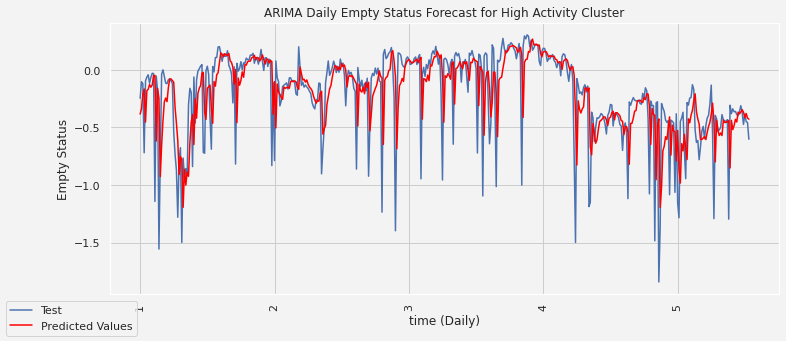

In [10]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(empty_cluster0.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Empty Status')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Empty Status Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

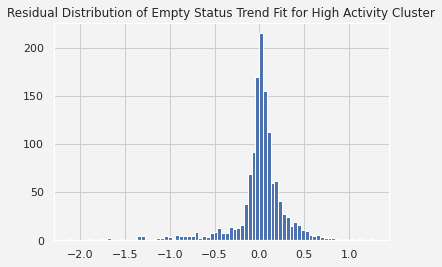

In [11]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Empty Status Trend Fit for High Activity Cluster')
plt.show

In [12]:
empty_cluster1 = pd.Series(daily_inventory[pd.IndexSlice[:,1,'Empty Alert']])

In [13]:
empty_cluster1,lam = boxcox(empty_cluster1)
empty_cluster1 = trans.fit_transform(empty_cluster1.reshape(-1,1))

In [14]:
empty_cluster1 = pd.DataFrame(empty_cluster1)

In [15]:
empty_status1_fit, predictions, test, residuals = model_creation(empty_cluster1)

Test RMSE: 0.434
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1332
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -726.039
Date:                Sun, 20 Dec 2020   AIC                           1464.078
Time:                        21:15:06   BIC                           1495.241
Sample:                             0   HQIC                          1475.757
                               - 1332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4748      0.016    -30.023      0.000      -0.506      -0.444
ar.L2         -0.4188      0.022    -18.927      0.000      -0.462      -0.375
ar.L3         -0.2809      0.026   

<ipython-input-16-b233bb46c335>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(empty_cluster1.index,rotation=90)


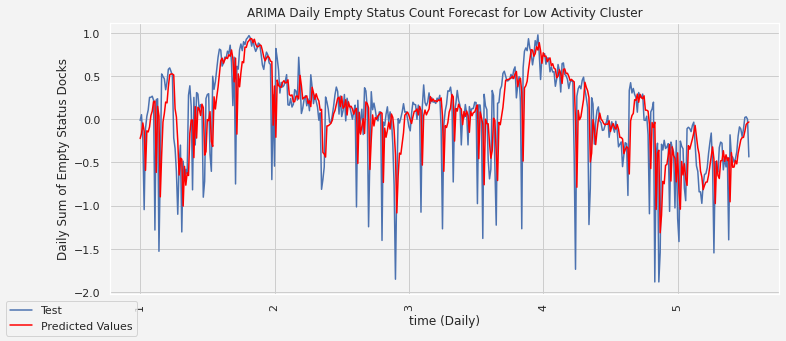

In [16]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(empty_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Empty Status Count Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

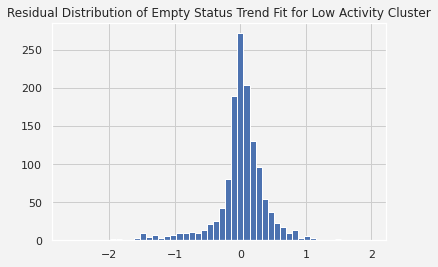

In [17]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 50)

plt.title('Residual Distribution of Empty Status Trend Fit for Low Activity Cluster')
plt.show

In [18]:
empty_cluster2 = pd.Series(daily_inventory[pd.IndexSlice[:,2,'Empty Alert']])

In [19]:
empty_cluster2,lam = boxcox(empty_cluster2)
empty_cluster2 = trans.fit_transform(empty_cluster2.reshape(-1,1))
empty_cluster2 = pd.DataFrame(empty_cluster2)

In [20]:
empty_status2_fit, predictions, test, residuals = model_creation(empty_cluster2)

Test RMSE: 0.297
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1332
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -250.918
Date:                Sun, 20 Dec 2020   AIC                            513.837
Time:                        21:16:49   BIC                            544.999
Sample:                             0   HQIC                           525.515
                               - 1332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4801      0.019    -25.241      0.000      -0.517      -0.443
ar.L2         -0.4397      0.023    -19.521      0.000      -0.484      -0.396
ar.L3         -0.3299      0.028   

<ipython-input-21-84af8e2fc738>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(empty_cluster2.index,rotation=90)


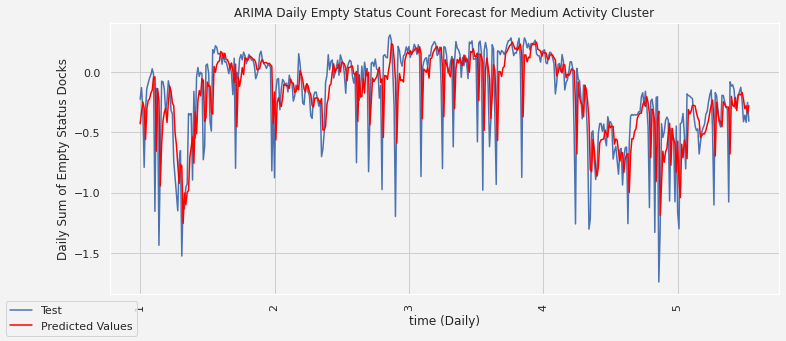

In [21]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(empty_cluster2.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Empty Status Count Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

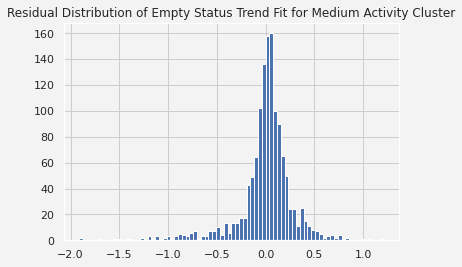

In [22]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Empty Status Trend Fit for Medium Activity Cluster')
plt.show

In [23]:
full_cluster0 = pd.Series(daily_inventory[pd.IndexSlice[:,0,'Full Alert']])

In [24]:
full_cluster0,lam = boxcox(full_cluster0)
full_cluster0 = trans.fit_transform(full_cluster0.reshape(-1,1))

In [25]:
full_cluster0 = pd.DataFrame(full_cluster0)

In [26]:
full_status0_fit, predictions, test, residuals = model_creation(full_cluster0)

Test RMSE: 0.399
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -700.079
Date:                Sun, 20 Dec 2020   AIC                           1412.158
Time:                        21:17:58   BIC                           1443.284
Sample:                             0   HQIC                          1423.826
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4166      0.018    -23.029      0.000      -0.452      -0.381
ar.L2         -0.3856      0.024    -15.896      0.000      -0.433      -0.338
ar.L3         -0.2981      0.025   

<ipython-input-27-bef4b64dfde9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(full_cluster0.index,rotation=90)


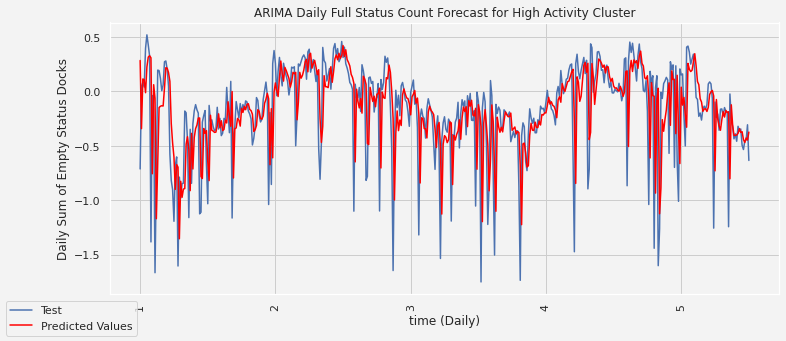

In [27]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(full_cluster0.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Full Status Count Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

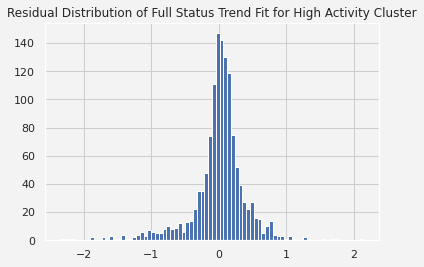

In [28]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Full Status Trend Fit for High Activity Cluster')
plt.show

In [29]:
full_cluster1 = pd.Series(daily_inventory[pd.IndexSlice[:,1,'Full Alert']])

In [30]:
full_cluster1,lam = boxcox(full_cluster1)
full_cluster1 = trans.fit_transform(full_cluster1.reshape(-1,1))

In [31]:
full_cluster1 = pd.DataFrame(full_cluster1)

In [32]:
full_status1_fit, predictions, test, residuals = model_creation(full_cluster1)

Test RMSE: 0.431
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1322
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -570.660
Date:                Sun, 20 Dec 2020   AIC                           1153.319
Time:                        21:19:12   BIC                           1184.436
Sample:                             0   HQIC                          1164.985
                               - 1322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4086      0.018    -22.258      0.000      -0.445      -0.373
ar.L2         -0.3300      0.025    -12.983      0.000      -0.380      -0.280
ar.L3         -0.2433      0.023   

<ipython-input-33-46c6384c0d21>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(full_cluster1.index,rotation=90)


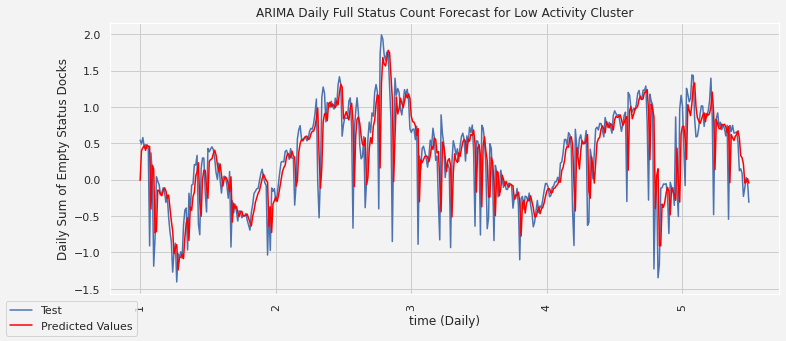

In [33]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(full_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Full Status Count Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

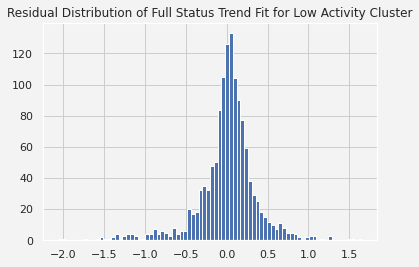

In [34]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Full Status Trend Fit for Low Activity Cluster')
plt.show

In [35]:
full_cluster2 = pd.Series(daily_inventory[pd.IndexSlice[:,2,'Full Alert']])

In [36]:
full_cluster2,lam = boxcox(full_cluster2)
full_cluster2 = trans.fit_transform(full_cluster2.reshape(-1,1))

In [37]:
full_cluster2 = pd.DataFrame(full_cluster2)

In [38]:
full_status2_fit, predictions, test, residuals = model_creation(full_cluster2)

Test RMSE: 0.329
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -491.212
Date:                Sun, 20 Dec 2020   AIC                            994.424
Time:                        21:20:21   BIC                           1025.550
Sample:                             0   HQIC                          1006.093
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3958      0.019    -20.818      0.000      -0.433      -0.358
ar.L2         -0.3580      0.022    -15.962      0.000      -0.402      -0.314
ar.L3         -0.2557      0.023   

<ipython-input-39-dabb7211e8f7>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(full_cluster2.index,rotation=90)


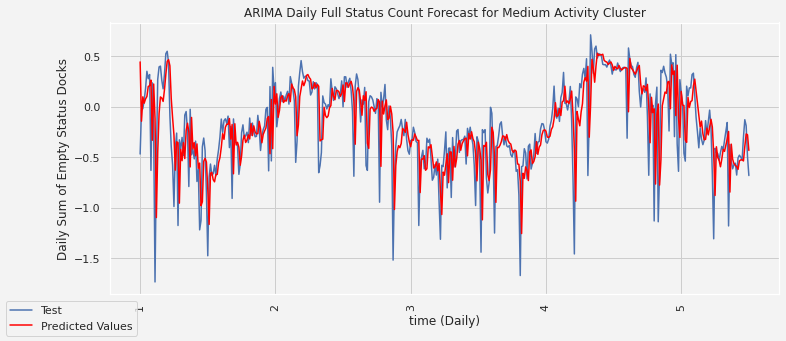

In [39]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(full_cluster2.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Full Status Count Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

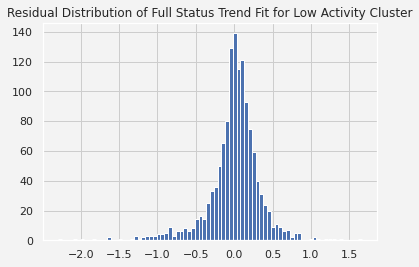

In [40]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Full Status Trend Fit for Low Activity Cluster')
plt.show

In [41]:
healthy_cluster0 = pd.Series(daily_inventory[pd.IndexSlice[:,0,'Healthy']])

In [42]:
healthy_cluster0,lam = boxcox(healthy_cluster0)
healthy_cluster0 = trans.fit_transform(healthy_cluster0.reshape(-1,1))

In [43]:
healthy_cluster0 = pd.DataFrame(healthy_cluster0)

<ipython-input-44-000f918949dd>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster0.index,rotation=90)


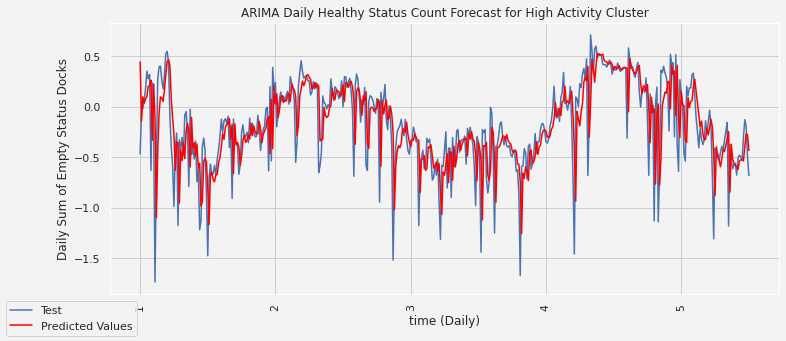

In [44]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster0.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Healthy Status Count Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

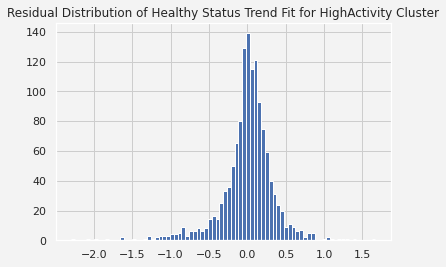

In [45]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Healthy Status Trend Fit for HighActivity Cluster')
plt.show

In [46]:
healthy_cluster1 = pd.Series(daily_inventory[pd.IndexSlice[:,1,'Healthy']])

In [47]:
healthy_cluster1,lam = boxcox(healthy_cluster1)
healthy_cluster1 = trans.fit_transform(healthy_cluster1.reshape(-1,1))
healthy_cluster1 = pd.DataFrame(healthy_cluster1)

In [48]:
healthy_status0_fit, predictions, test, residuals = model_creation(healthy_cluster0)

Test RMSE: 0.323
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1325
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -455.534
Date:                Sun, 20 Dec 2020   AIC                            923.069
Time:                        21:21:34   BIC                            954.199
Sample:                             0   HQIC                           934.738
                               - 1325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4757      0.016    -29.775      0.000      -0.507      -0.444
ar.L2         -0.4226      0.022    -18.938      0.000      -0.466      -0.379
ar.L3         -0.3172      0.026   

<ipython-input-49-000f918949dd>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster0.index,rotation=90)


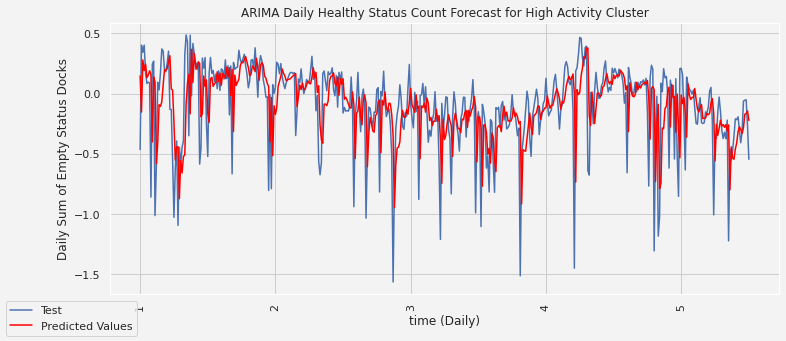

In [49]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster0.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Healthy Status Count Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

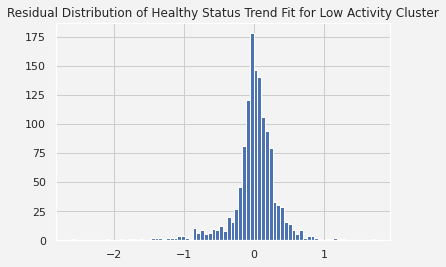

In [50]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 80)

plt.title('Residual Distribution of Healthy Status Trend Fit for Low Activity Cluster')
plt.show

In [51]:
healthy_status1_fit, predictions, test, residuals = model_creation(healthy_cluster1)

Test RMSE: 0.463
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1332
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -847.260
Date:                Sun, 20 Dec 2020   AIC                           1706.519
Time:                        21:22:39   BIC                           1737.681
Sample:                             0   HQIC                          1718.198
                               - 1332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4036      0.016    -25.063      0.000      -0.435      -0.372
ar.L2         -0.3392      0.019    -17.536      0.000      -0.377      -0.301
ar.L3         -0.2402      0.021   

<ipython-input-52-4e73ced5f849>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster1.index,rotation=90)


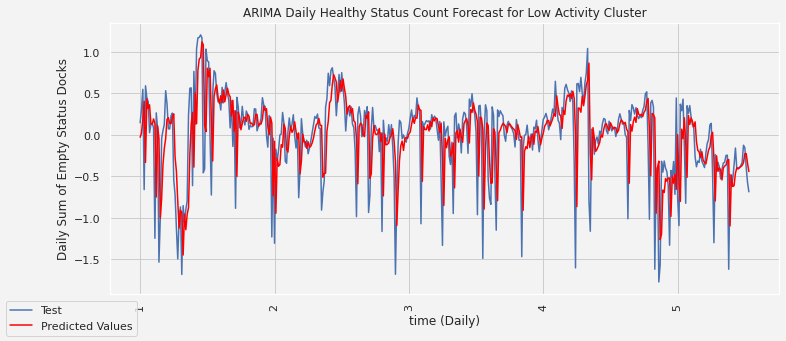

In [52]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Healthy Status Count Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

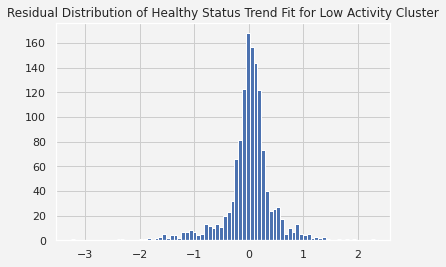

In [53]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals,bins = 80)

plt.title('Residual Distribution of Healthy Status Trend Fit for Low Activity Cluster')
plt.show

In [79]:
healthy_cluster2 = pd.Series(daily_inventory[pd.IndexSlice[:,2,'Healthy']])

In [80]:
healthy_cluster2,lam = boxcox(healthy_cluster2.values)
healthy_cluster2 = trans.fit_transform(healthy_cluster2.reshape(-1,1))
healthy_cluster2 = pd.DataFrame(healthy_cluster2)

In [81]:
healthy_status2_fit, predictions, test, residuals = model_creation(healthy_cluster2)

Test RMSE: 0.346
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1325
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -504.028
Date:                Sun, 20 Dec 2020   AIC                           1020.056
Time:                        21:30:44   BIC                           1051.187
Sample:                             0   HQIC                          1031.726
                               - 1325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4436      0.016    -27.463      0.000      -0.475      -0.412
ar.L2         -0.4152      0.023    -17.917      0.000      -0.461      -0.370
ar.L3         -0.3264      0.025   

<ipython-input-82-f6257f889160>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster1.index,rotation=90)


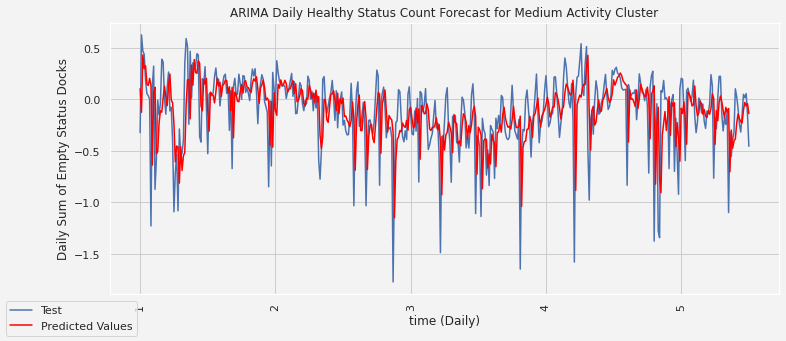

In [82]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Healthy Status Count Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

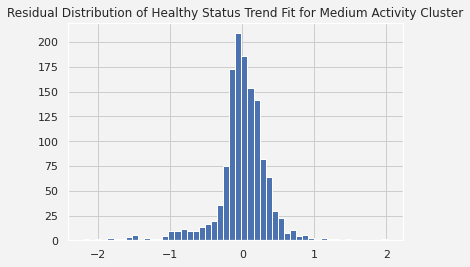

In [83]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 50)

plt.title('Residual Distribution of Healthy Status Trend Fit for Medium Activity Cluster')
plt.show

<ipython-input-84-093bbcb05dab>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster1.index,rotation=90)


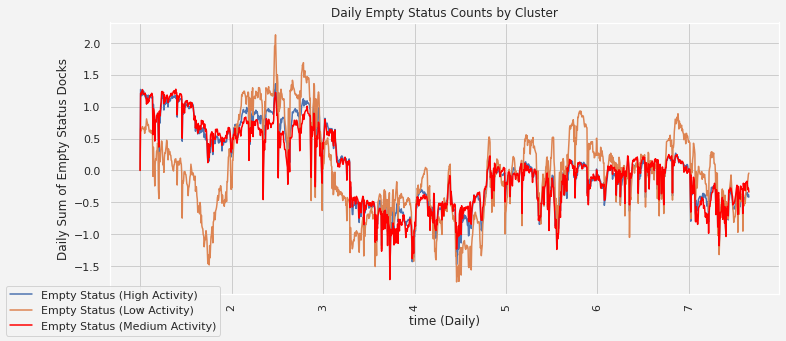

In [84]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Empty Status Docks')
plt.plot(empty_status0_fit.fittedvalues)
plt.plot(empty_status1_fit.fittedvalues)
plt.plot(empty_status2_fit.fittedvalues, color='red')
fig.legend(['Empty Status (High Activity)','Empty Status (Low Activity)', 'Empty Status (Medium Activity)'], loc=3)
plt.title('Daily Empty Status Counts by Cluster')
plt.show()

<ipython-input-85-9eb99e0ef440>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster1.index,rotation=90)


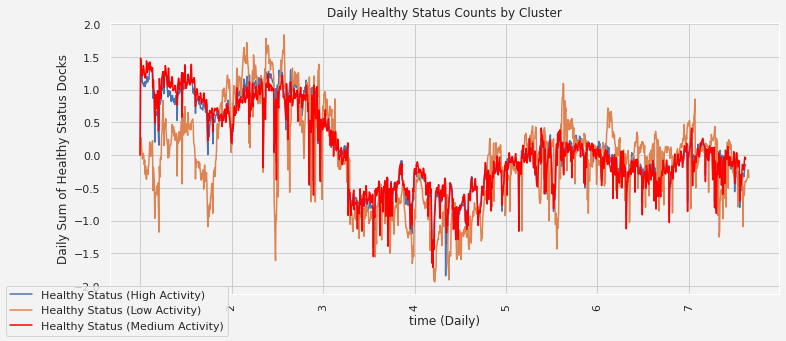

In [85]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Healthy Status Docks')
plt.plot(healthy_status0_fit.fittedvalues)
plt.plot(healthy_status1_fit.fittedvalues)
plt.plot(healthy_status2_fit.fittedvalues, color='red')
fig.legend(['Healthy Status (High Activity)','Healthy Status (Low Activity)', 'Healthy Status (Medium Activity)'], loc=3)
plt.title('Daily Healthy Status Counts by Cluster')
plt.show()

<ipython-input-86-13fd3bc77f11>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(healthy_cluster1.index,rotation=90)


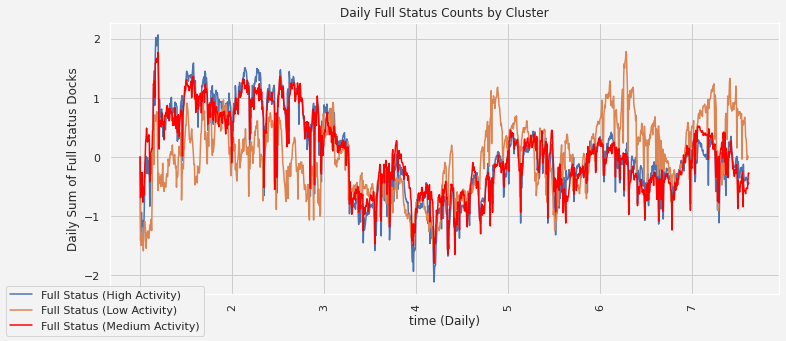

In [86]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(healthy_cluster1.index,rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Daily Sum of Full Status Docks')
plt.plot(full_status0_fit.fittedvalues)
plt.plot(full_status1_fit.fittedvalues)
plt.plot(full_status2_fit.fittedvalues, color='red')
fig.legend(['Full Status (High Activity)','Full Status (Low Activity)', 'Full Status (Medium Activity)'], loc=3)
plt.title('Daily Full Status Counts by Cluster')
plt.show()

In [87]:
fitted_models = pd.DataFrame({'full_status0' : pd.Series(full_status0_fit.fittedvalues), 
                              'full_status1' : pd.Series(full_status1_fit.fittedvalues), 
                              'full_status2' : pd.Series(full_status2_fit.fittedvalues), 
                              'empty_status0' : pd.Series(empty_status0_fit.fittedvalues),
                              'empty_status1' : pd.Series(empty_status1_fit.fittedvalues), 
                              'empty_status2' : pd.Series(empty_status2_fit.fittedvalues),
                              'healthy_status0' : pd.Series(healthy_status0_fit.fittedvalues),
                              'healthy_status1' : pd.Series(healthy_status1_fit.fittedvalues),
                              'healthy_status2' : pd.Series(healthy_status2_fit.fittedvalues)})

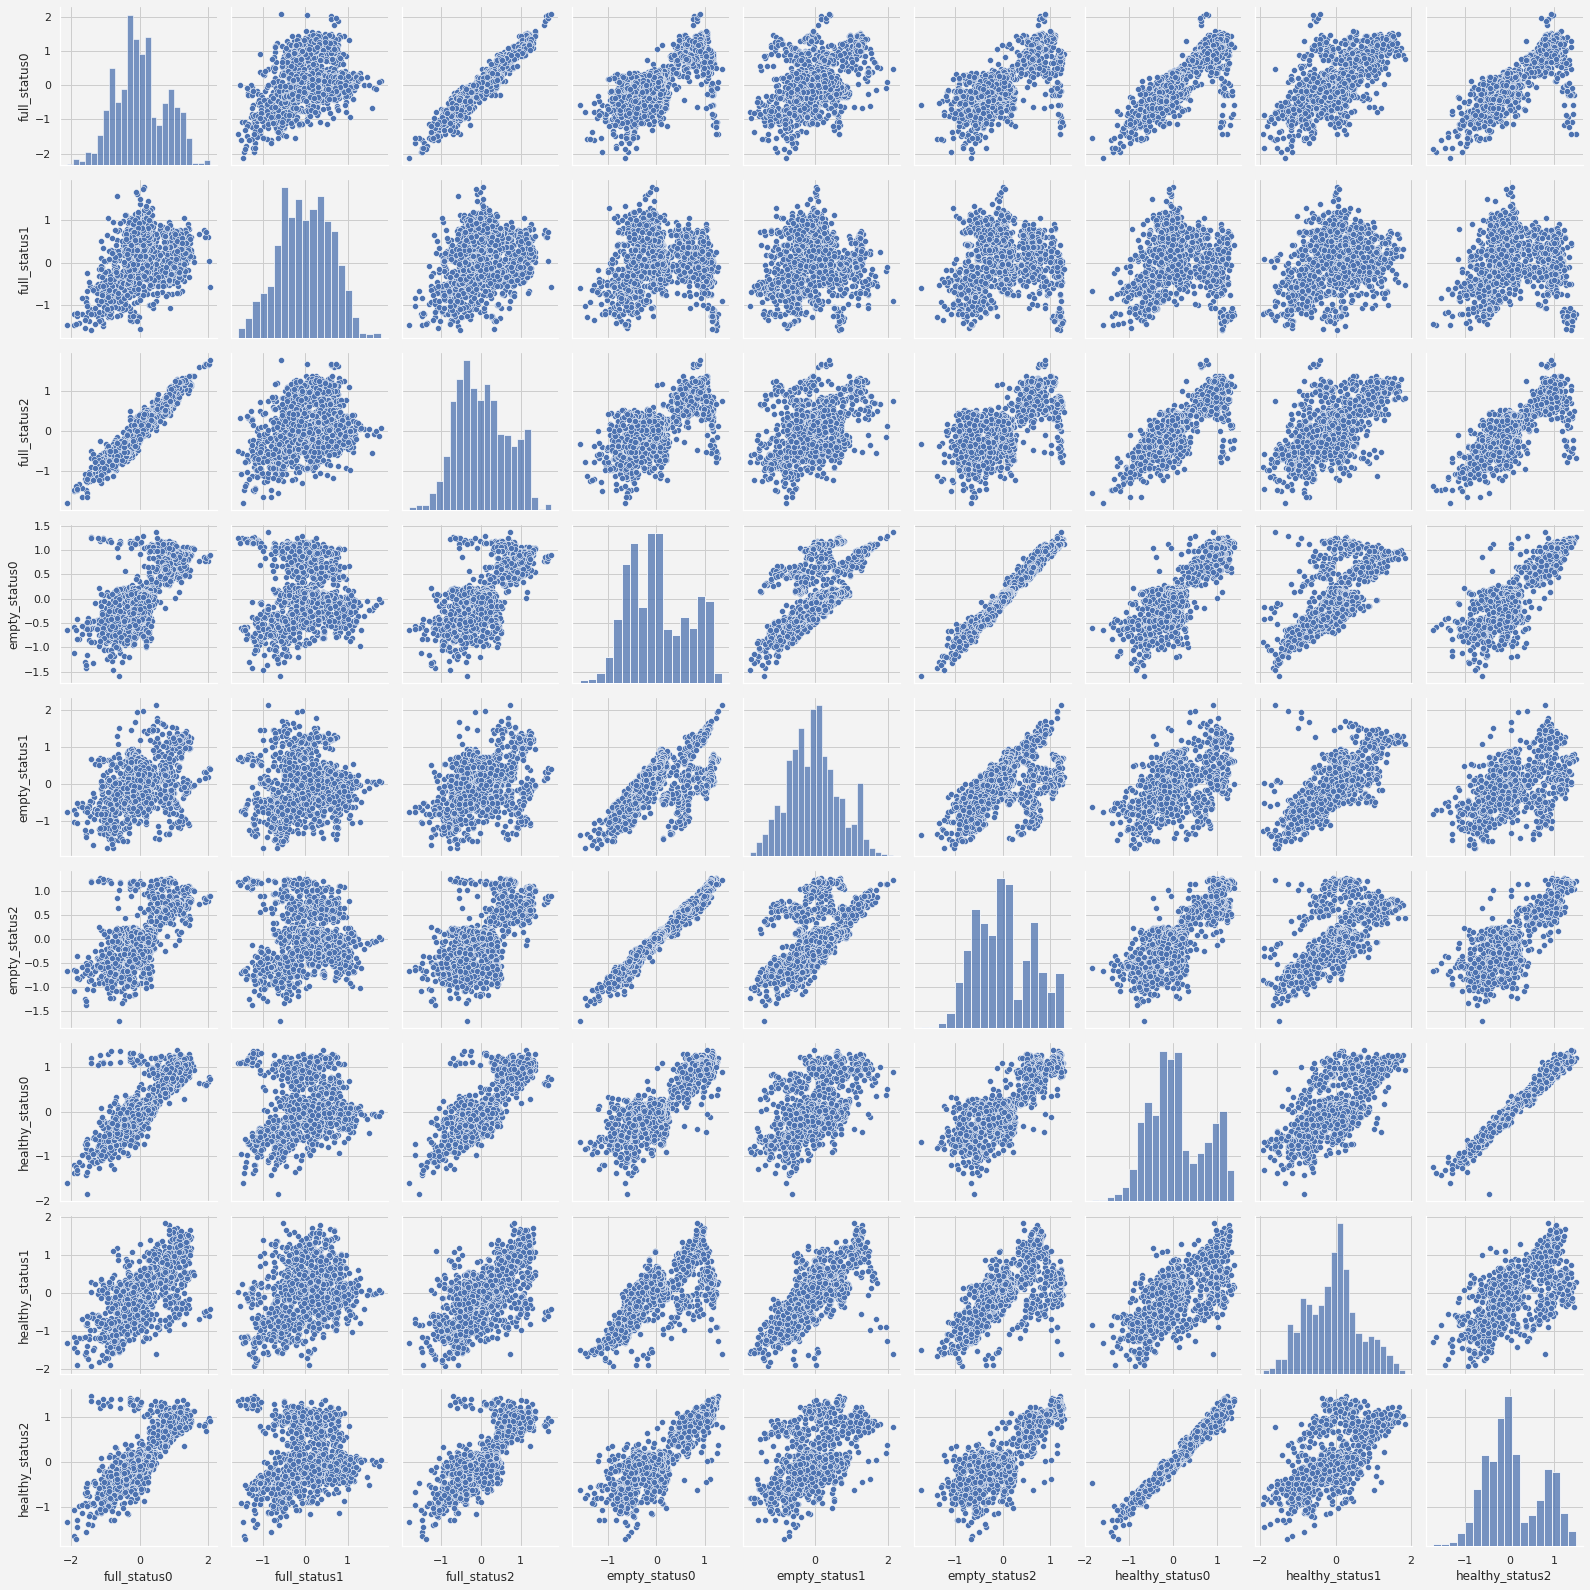

In [88]:
sns.pairplot(fitted_models)

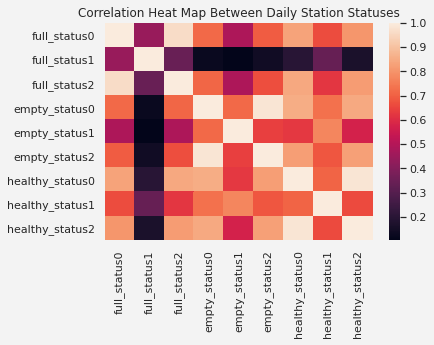

In [89]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.figsize = (12,5)
sns.heatmap(fitted_models.corr())
plt.title('Correlation Heat Map Between Daily Station Statuses')
plt.show()